In [254]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import importlib
import galaxy

from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde
# from rbf.interpolate import Interpolant
from scipy.spatial import KDTree
from scipy.stats import rankdata

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [2]:
def load_log(fname):
    log = np.genfromtxt(fname)
    _, indices = np.unique(log[:,0], return_index=True)
    log = log[sorted(indices)]
    return log

In [3]:
idx = 260

gals = {}
Rs = '142'
Vv = '142'
ecc = '04'
lvl = '4'

key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
gal = galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output', idx, orient=True)

In [298]:
def get_logFeH_logMgFe(gal, ptype=4):
    GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
    GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
    GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
    
    part = getattr(gal.sn, 'part'+str(ptype))
    
    FeH = part.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    logFeH = np.log10(FeH)

    MgH = part.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    MgFe = MgH/FeH
    logMgH = np.log10(MgH)
    logMgFe = np.log10(MgFe)
    
    return logFeH, logMgH, logMgFe

def in_SN(gal, ptype, Rmin=4, Rmax=16, zmin=0, zmax=3, dLz=0.1):
    part = getattr(gal.sn, 'part'+str(ptype))
    # R = np.linalg.norm(part.rotpos[:,:2], axis=1)
    # z = part.rotpos[:,2]
    # key_R = np.logical_and(R < Rmax, R > Rmin)
    # key = np.logical_and(key_R, np.abs(z) < zmax)
    # key = np.logical_and(key, np.abs(z) > zmin)
    
    pos = part.rotpos
    vel = part.rotvel
    Lz = np.cross(pos, vel)[:,2]
    
    Lzsun = 8*220
    key = np.logical_and((Lz/Lzsun)-1 < dLz, np.abs(pos[:,2]) < zmax)
    
    return key
    
def plot_map(fig, ax, gal, scalar=None, subsamp=None, tform_min=0, tform_max=10,
             Rmin=4, Rmax=16, zmin=0, zmax=3, exclude=None, nres=50, sigma=1,
             logFeH_min=-1.1, logFeH_max=0.4, logMgFe_min=0.15, logMgFe_max=0.65,
             K=64, vmin=None, vmax=None, asymmetry=False, norm=0, cmap=None):
    
    # vmin = None
    # vmax = 0.008
    # vmax = None
    
    logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)
    
    key = in_SN(gal, 4, Rmin=Rmin, Rmax=Rmax, zmin=zmin, zmax=zmax)
    
    tform = gal.sn.part4.GFM_StellarFormationTime
    key = np.logical_and(key, tform > tform_min)
    key = np.logical_and(key, tform < tform_max)
    
    if exclude is not None:
        key_low = np.logical_and(key, tform < exclude[0])
        key_high = np.logical_and(key, tform > exclude[1])
        key = np.logical_or(key_low, key_high)
    
    data = np.vstack((logFeH[key], logMgFe[key])).T
    N = len(data)
    tree = KDTree(data)
        
    dlogFeH = (logFeH_max - logFeH_min)/nres
    dlogMgFe = (logMgFe_max - logMgFe_min)/nres
        
    logFeH_lin = np.linspace(logFeH_min + dlogFeH, logFeH_max-dlogFeH, nres)
    logMgFe_lin = np.linspace(logMgFe_min + dlogMgFe, logMgFe_max-dlogMgFe, nres)
    
    logFeH_grid, logMgFe_grid = np.meshgrid(logFeH_lin, logMgFe_lin)
    grid = np.vstack([logFeH_grid.ravel(), logMgFe_grid.ravel()]).T

    distances, indices = tree.query(grid, k=K)
    kth_distances = distances[:, -1]
    
    tmp = np.reshape(kth_distances, (nres, nres))
    
    # Calculate the density: Inverse of the area of the circle surrounding the Kth neighbor
    density = K / (N * np.pi * kth_distances**2)
    density = np.reshape(density, logFeH_grid.shape).T
    
    downstairs = np.max(density, axis=1)
    
    # downstairs = np.sum(mbin, axis=1)
    # vmin = 0.01
    # vmax = 0.2
    
    downstairs[downstairs == 0.0] = 1e-20
    density = (density.T / downstairs).T
    density[density < vmin] = vmin
        
    extent = [logFeH_min, logFeH_max, logMgFe_min, logMgFe_max]
    
    if norm == 0:
        # norm = None
        norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
        # norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        # norm = mpl.colors.PowerNorm(gamma=0.5)
    
    # density = density**alpha
    # density[density > 1] = density[density > 1]**0.3
    if asymmetry:
        # grad_logFeH, grad_logMgFe = np.gradient(density)
        # grad_mag = np.sqrt(grad_logFeH**2 + grad_logMgFe**2)
        # density = grad_mag/density
        # density = grad_logMgFe
        # print(grad_mag.shape)
        
        neighbors = data[indices]
        print(neighbors.shape)
        com = np.mean(neighbors, axis=1)
        print(com.shape)
        d = distances[:,-1]
        asymmetry_values = (com[:, 1] - grid[:, 1]) / d
        
        tenperc = np.percentile(density, 10)
        tenperc = density < tenperc
        
        asymmetry_grid = asymmetry_values.reshape((nres, nres)).T
        density = asymmetry_grid
        # density[tenperc] = 0.0
        
    
    # percentiles = np.zeros_like(density)
    # for i in range(density.shape[1]):
        # column = density[i,:]
        # density[i,:] = rankdata(density[i,:], method='max') / len(column)
    
    print(norm)
    
    im = ax.imshow(density.T, origin='lower',
               extent=extent,
               norm=norm, cmap=cmap)

    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect('auto')
    
    return im

[Text(0, 0.5, '[Mg/Fe]')]

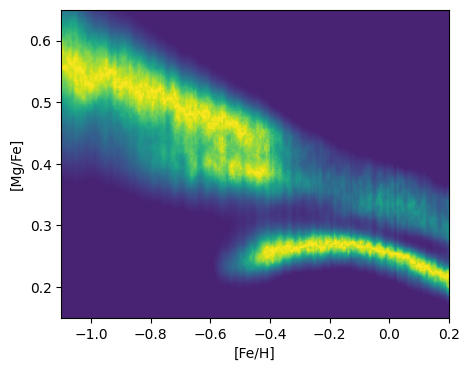

In [301]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

logvmin = -1
logvmax = 1.8
im = plot_map(fig, ax, gal, nres=256, sigma=7, logFeH_max=0.2, K=256,
              Rmin=7, Rmax=9,
             vmin = 10.**(logvmin), vmax=10.**(logvmax), norm=mpl.colors.Normalize(0, 1))

# fig.colorbar(im, ax=ax)

ax.set(xlabel='[Fe/H]')
ax.set(ylabel='[Mg/Fe]')

None


[Text(0, 0.5, '[Mg/Fe]')]

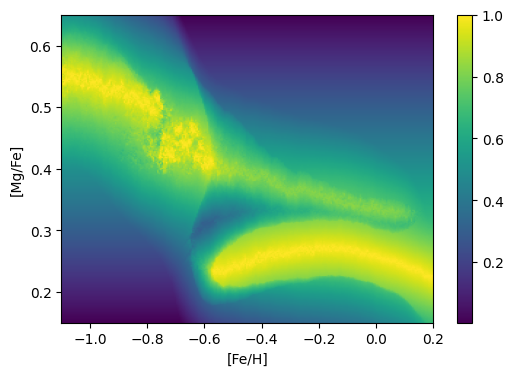

In [266]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

logvmin = -2
logvmax = -0.1
# im, rho = plot_map(fig, ax, gal, nres=256, sigma=7, logFeH_max=0.2, K=512,
             # vmin=10.**logvmin, vmax=10.**logvmax)
    
im, rho = plot_map(fig, ax, gal, nres=256, sigma=7, logFeH_max=0.2, K=256,
             vmin=1e-4, vmax=None, norm=None)

fig.colorbar(im, ax=ax)

ax.set(xlabel='[Fe/H]')
ax.set(ylabel='[Mg/Fe]')

/tmp/ipykernel_1495578/1683800011.py:4: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(rho_h).ravel(), bins=100);


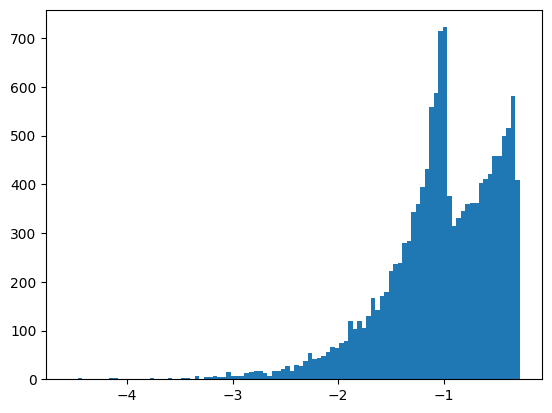

In [228]:
rho_h = np.copy(rho)
# rho_h[rho_h > 1] = rho_h[rho_h>1]**0.3
rho_h = np.log10(rho_h)
plt.hist(np.log10(rho_h).ravel(), bins=100);

(65536, 512, 2)
(65536, 2)


[Text(0, 0.5, '[Mg/Fe]')]

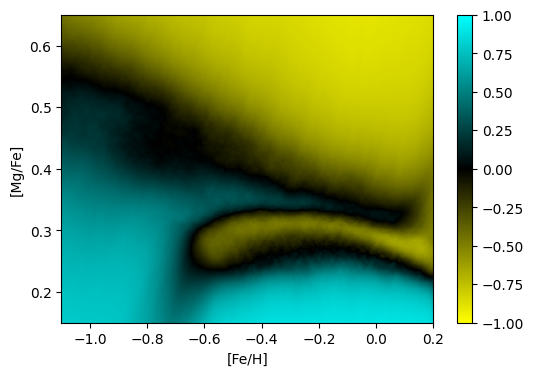

In [286]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return mpl.colors.LinearSegmentedColormap('colormap',cdict,1024)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

logvmin = -2
logvmax = -0.1
# im, rho = plot_map(fig, ax, gal, nres=256, sigma=7, logFeH_max=0.2, K=512,
             # vmin=10.**logvmin, vmax=10.**logvmax, alpha=0.5, gradient=True)
    
inv = cmap_map(lambda x: 1-x, mpl.cm.bwr)
im, rho = plot_map(fig, ax, gal, nres=256, sigma=7, logFeH_max=0.2, K=512,
                   asymmetry=True, norm=mpl.colors.Normalize(-1, 1), cmap=inv)

fig.colorbar(im, ax=ax)

ax.set(xlabel='[Fe/H]')
ax.set(ylabel='[Mg/Fe]')

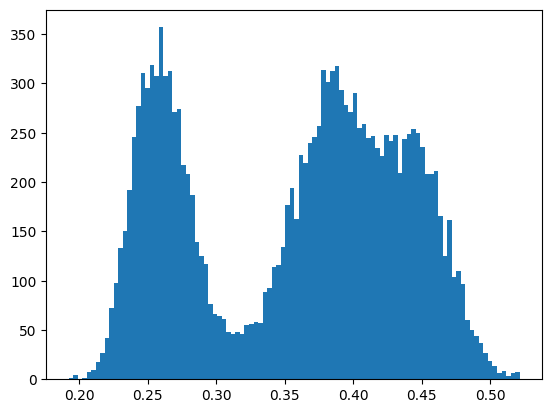

In [280]:
logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)

key = np.logical_and(logFeH > -0.45, logFeH < -0.35)
plt.hist(logMgFe[key], bins=100);